# ESG Performance and Financial Outcomes Across UK Industries: Evidence From The FTSE 350  
## Data Source: LSEG Refinitiv (extracted to Excel)

### LOAD LIBRARIES

In [3]:
import pandas as pd #Import pandas library as pd
import numpy as np #Import numpy library as np
import matplotlib.pyplot as plt #Import pyplot from matplotlib as plt
import seaborn as sns #Import seaborn library as sns
import statsmodels.api as sm #Import statsmodels.api as sm
from scipy.stats.mstats import winsorize #Import winsorize function
from sklearn.compose import ColumnTransformer #Import ColumnTransformer class
from sklearn.pipeline import Pipeline #Import Pipeline class
from sklearn.impute import SimpleImputer #Import SimpleImputer class
from sklearn.preprocessing import StandardScaler, OneHotEncoder #Import scaler and encoder
from sklearn.model_selection import train_test_split, GridSearchCV #Import data splitting and hyperparameter tuning tools
from sklearn.linear_model import Lasso #Import Lasso regression model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor #Import ensemble regression models
from sklearn.metrics import mean_absolute_error, r2_score #Import evaluation metrics

### LOAD DATA, TRANSFORM & EXPORT FOR FURTHER ANALYSIS

##### Objective: Handle missing data via industry-stratified imputation and reshape longitudinal data for analysis.

# SECTION 1: DATA RESHAPING

### 1.1 Load Data Extracted from LSEG Refinitiv

In [8]:
data = pd.read_excel('ESG_DATA_1.xlsx') #Load Excel file into DataFrame named 'data'

In [9]:
data.head() #Display first five rows of the DataFrame

,Identifier,Company Name,ESG Score\n(False)\nIn the last 5 FY,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,ESG Combined Score\n(False)\nIn the last 5 FY,Unnamed: 8,Unnamed: 9,...,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Return on Average Total Equity - %\n(False)\nIn the last 5 FY,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,1 Month Total Return
0,NaN,NaN,FY0,FY-1,FY-2,FY-3,FY-4,FY0,FY-1,FY-2,...,FY-1,FY-2,FY-3,FY-4,FY0,FY-1,FY-2,FY-3,FY-4,NaN
1,HLMA.L,Halma PLC,63.137917,63.137917,63.137917,63.137917,63.137917,63.137917,63.137917,63.137917,...,67690638.281381,67690638.281381,67690638.281381,67690638.281381,0.163041,0.163041,0.163041,0.163041,0.163041,0.055291
2,ENT.L,Entain PLC,77.42315,77.42315,77.42315,77.42315,77.42315,49.918472,49.918472,49.918472,...,24396346.803453,24396346.803453,24396346.803453,24396346.803453,-0.1916,-0.1916,-0.1916,-0.1916,-0.1916,0.062536
3,TATE.L,Tate & Lyle PLC,58.586746,58.586746,58.586746,58.586746,58.586746,58.586746,58.586746,58.586746,...,65882109.77768,65882109.77768,65882109.77768,65882109.77768,0.029006,0.029006,0.029006,0.029006,0.029006,-0.004395
4,MNDI.L,Mondi PLC,81.832315,81.832315,81.832315,81.832315,81.832315,81.832315,81.832315,81.832315,...,0,0,0,0,0.045605,0.045605,0.045605,0.045605,0.045605,0.039571


### 1.2 Longitudinal Reshaping Logic

##### The code below carries out preliminary data cleaning and restructuring. It removes an initial non-data row, standardises fiscal year columns, and scans the dataset to identify grouped fiscal-year data. Each group is then reshaped from a wide format into a long, tidy structure and stored for later use, allowing consistent analysis across multiple variables.


In [12]:
data_clean = data.drop(index=0).reset_index(drop=True) #Remove the first row and reset the DataFrame index
id_cols, fy_labels = ['Identifier', 'Company Name'], ['FY0', 'FY-1', 'FY-2', 'FY-3', 'FY-4'] #Define lists for IDcolumns & fiscal year labels
all_chunks = [] #Initialise an empty list to store data chunks

In [13]:
current_col = 2 #Initialise column index counter at 2
while current_col < len(data_clean.columns): #Loop while current column index is within DataFrame bounds
    if data.iloc[0, current_col] == 'FY0': #Check if the top cell contains the 'FY0' label
        block = data_clean.iloc[:, current_col : current_col + 5].copy() #Extract a 5-column block for the FY data
        block.columns = fy_labels #Assign the standard fiscal year labels to the block columns
        var_name = str(data_clean.columns[current_col]).split('\n')[0].strip() #Extract the variable name from the header
        melted = pd.concat([data_clean[id_cols], block], axis=1).melt( #Merge ID columns with block and melt into long format
            id_vars=id_cols, var_name='Fiscal_Year', value_name='Value'
        )
        melted['Variable'] = var_name #Add a new column for the variable name
        all_chunks.append(melted) #Append the melted DataFrame chunk to the master list
        current_col += 5 #Advance column index by 5 to skip the processed block
    else: current_col += 1 #Otherwise, advance column index by 1

### 1.3 Pivot to Master Format

##### The code below combines all previously reshaped data segments into a single DataFrame, then reorganises the data so that each row represents a unique company–fiscal year observation. Variables are pivoted into separate columns, with values aligned accordingly, producing a clean, analysis-ready dataset in a structured wide format.


In [16]:
df_reshaped = pd.concat(all_chunks, ignore_index=True).pivot_table( #Concatenate all chunks and pivot from long to wide format
    index=['Identifier', 'Company Name', 'Fiscal_Year'], #Set these columns as the new index for the pivot
    columns='Variable', values='Value', aggfunc='first' #Use 'Variable' names as new columns, 'Value' as data, keep first value
).reset_index() #Convert the index back into regular DataFrame columns

### 1.4 Export Cleaned Master Dataset

In [18]:
# Cleaned Data saved as new excel for further analysis
df_reshaped.to_excel("Master_Cleaned_ESG_Data.xlsx", index=False) #Export DataFrame to an Excel file 
print("Reshaped data saved to 'Master_Cleaned_ESG_Data.xlsx'") #Print a confirmation message to the console

Reshaped data saved to 'Master_Cleaned_ESG_Data.xlsx'


# SECTION 2: BASIC INSPECTION & DESCRIPTIVE STATISTICS

#### 2.1 Load the New Dataset

In [21]:
# Load dataset
df = pd.read_excel("Master_Cleaned_ESG_Data.xlsx")

#### 2.2 Formatting Numeric Columns

In [23]:
# Format Numeric Columns
numeric_vars = df.columns.difference(['Identifier', 'Company Name', 'Fiscal_Year']) #Identify columns that are not ID or year columns
for col in numeric_vars: #Iterate through each numeric column name
    df[col] = pd.to_numeric(df[col], errors='coerce') #Convert column to numeric type, forcing non-numeric values to NaN

#### 2.3 Descriptive Summary

In [25]:
print("\nSTATISTICAL SUMMARY\n") #Print a heading for the summary
print(df.describe()) #Print descriptive statistics for the DataFrame


STATISTICAL SUMMARY

       Actual Return on Assets  Audit Committee Independence         Beta  \
count             2.050000e+02                   1571.000000  1687.000000   
mean              2.689571e+08                     95.794636     1.140231   
std               1.338519e+09                     10.478763     0.614003   
min              -2.479000e+09                     16.666667    -0.291663   
25%               0.000000e+00                    100.000000     0.702014   
50%               2.439635e+07                    100.000000     1.057094   
75%               9.869398e+07                    100.000000     1.534325   
max               5.318000e+09                    100.000000     4.597073   

       Board Gender Diversity, Percent   Board Size  \
count                      1571.000000  1571.000000   
mean                         43.476929     8.598345   
std                           9.977745     2.316041   
min                          14.285714     4.000000   
25%      

#### 2.4 HANDLING MISSING VALUES

In [27]:
print("\nMISSING VALUES AUDIT\n") #Print a heading for the missing value audit
print(df.isnull().sum()[df.isnull().sum() > 0]) #Print count of missing values only for columns that have any


MISSING VALUES AUDIT

Actual Return on Assets               1541
Audit Committee Independence           175
Beta                                    59
Board Gender Diversity, Percent        175
Board Size                             175
CEO-Chairman Separation Score          175
CSR Strategy Score                     175
Community Score                        176
Company Market Cap                      26
ESG Combined Score                     175
ESG Controversies Score                176
ESG Score                              175
Emissions Score                        176
Environmental Innovation Score         176
Environmental Pillar Score             176
Governance Pillar Score                175
Human Rights Score                     176
Independent Board Members Score        175
Management Score                       175
Price Close                             32
Product Responsibility Score           176
Resource Use Score                     176
Return on Average Total Equity 

In [28]:
# Industry Median Imputation
# Merging industry names back for stratified cleaning
industry_map = data[['Identifier', 'ICB Industry name']].drop_duplicates() #Create a mapping DataFrame linking IDs to their industry
df = pd.merge(df, industry_map, on='Identifier', how='left') #Merge the industry column onto the main DataFrame using the ID

df = df.dropna(subset=['ESG Score']).copy() #Drop all rows where the 'ESG Score' column has a missing value
num_cols = df.select_dtypes(include=['number']).columns #Identify all columns that have numeric data types
df[num_cols] = df.groupby('ICB Industry name')[num_cols].transform(lambda x: x.fillna(x.median())) #Fill missing values with median
df = df.dropna().reset_index(drop=True) #Drop any remaining rows with missing values and reset the index

In [29]:
print("\nMISSING VALUES AFTER IMPUTATION:\n") #Print a heading for the post-imputation audit
print(df.isnull().sum()) #Print the sum of missing values for every column in the DataFrame


MISSING VALUES AFTER IMPUTATION:

Identifier                            0
Company Name                          0
Fiscal_Year                           0
Actual Return on Assets               0
Audit Committee Independence          0
Beta                                  0
Board Gender Diversity, Percent       0
Board Size                            0
CEO-Chairman Separation Score         0
CSR Strategy Score                    0
Community Score                       0
Company Market Cap                    0
ESG Combined Score                    0
ESG Controversies Score               0
ESG Score                             0
Emissions Score                       0
Environmental Innovation Score        0
Environmental Pillar Score            0
Governance Pillar Score               0
Human Rights Score                    0
Independent Board Members Score       0
Management Score                      0
Price Close                           0
Product Responsibility Score          0
Resou

# SECTION 3: FEATURE ENGINEERING

##### In the code below, ESG variables are lagged by one period to reduce endogeneity risk by ensuring that ESG performance precedes the financial outcome. Logarithmic transformations are then applied to relevant variables to address skewness and support more stable linear relationships, and interaction terms are constructed to test whether the relationship between ESG and performance is moderated by other firm characteristics. Finally, ROE is winsorised at the specified cut-offs to limit the influence of extreme observations while maintaining the sample size for the regression analysis (Rivest, 1994).


#### 3.1 Lagging ESG (t-1) for Endogeneity Control

In [33]:
df_fy0 = df[df['Fiscal_Year'] == 'FY0'].copy() #Create a DataFrame containing only data for the FY0 fiscal year
df_fym1 = df[df['Fiscal_Year'] == 'FY-1'][['Identifier', 'ESG Score']].rename(columns={'ESG Score': 'Lagged_ESG_Score'}) 
#Create a DataFrame containing the previous year's ESG Score, renaming it
data_merged = pd.merge(df_fy0, df_fym1, on='Identifier', how='inner') #Inner join the FY0 data with the lagged ESG Score using the ID

#### 3.2 Log Transforms & Interaction (Moderation)

In [35]:
data_merged['Firm_Size_Log'] = np.log(data_merged['Company Market Cap'].replace(0, np.nan)) 
#Create a log-transformed firm size variable, handling zeros as NaN
data_merged['Interaction_ESG_Size'] = data_merged['Lagged_ESG_Score'] * data_merged['Firm_Size_Log'] 
#Create an interaction term between lagged ESG score and logged firm size

#### 3.3 Winsorisation of Dependent Variable (ROE)

In [37]:
DV = 'Return on Average Total Equity - %' #Define the name of the dependent variable column
data_merged[DV] = winsorize(data_merged[DV], limits=[0.01, 0.01]) 
#Winsorise the dependent variable to cap extreme values at 1st and 99th percentiles

# SECTION 4: ECONOMETRIC MODELLING & HYPOTHESIS TESTING

##### Following the use of robust standard errors to address potential heteroscedasticity, the code estimates an ordinary least squares regression to test the study’s core hypotheses. Lagged ESG performance is included as the main explanatory variable to assess its effect on financial performance, while firm size and an interaction term between ESG and firm size are introduced to examine whether the ESG–performance relationship varies with firm scale. Additional control variables are incorporated to account for governance structure and market risk. The model is estimated using HC3 robust standard errors so that statistical inference remains reliable in the presence of heteroscedasticity, which is commonly observed in firm-level financial data in the FTSE 350 .

##### HYPOHTHESIS TESTING FOR H1 & H2
##### H1: ESG influences Financial Performance
##### H2: Firm Size moderates the ESG-Performance relationship via Interaction Term

In [41]:
#H1: ESG influences Financial Performance
#H2: Firm Size moderates the ESG-Performance relationship via Interaction Term
iv_cols = ['Lagged_ESG_Score', 'Firm_Size_Log', 'Interaction_ESG_Size', 'Board Size', 'Beta'] #Define list of I.V columns
X_ols = sm.add_constant(data_merged[iv_cols]) #Add a constant (intercept) term to the independent variables
y_ols = data_merged[DV] #Define the dependent variable for the model

#Fit model with HC3 Robust Standard Errors
ols_results = sm.OLS(y_ols, X_ols).fit(cov_type='HC3') #Fit Ordinary Least Squares model using HC3 robust standard errors

#### 4.1: OLS REGRESSION SUMMARY

In [43]:
print("\n4.1: OLS REGRESSION SUMMARY (Direct Effect & Moderation)") #Print a descriptive heading for the regression output
print(ols_results.summary()) #Print the detailed summary of the fitted OLS model


4.1: OLS REGRESSION SUMMARY (Direct Effect & Moderation)
                                    OLS Regression Results                                    
Dep. Variable:     Return on Average Total Equity - %   R-squared:                       0.048
Model:                                            OLS   Adj. R-squared:                  0.031
Method:                                 Least Squares   F-statistic:                     3.372
Date:                                Mon, 19 Jan 2026   Prob (F-statistic):            0.00563
Time:                                        16:37:43   Log-Likelihood:                 125.08
No. Observations:                                 293   AIC:                            -238.2
Df Residuals:                                     287   BIC:                            -216.1
Df Model:                                           5                                         
Covariance Type:                                  HC3                                  

#### 4.2 FORMAL MEDIATION ANALYSIS (PATHWAY MODELLING)

##### This section implements a formal mediation analysis to examine whether governance, proxied by board size, acts as a transmission mechanism between ESG performance and financial outcomes. First, Path A estimates the effect of ESG on the proposed mediator by regressing board size on lagged ESG, establishing whether ESG performance is associated with governance structure. Next, Paths B and C are estimated jointly by regressing financial performance on both board size and ESG, while controlling for firm size, allowing the analysis to assess the direct effect of ESG alongside the indirect effect operating through governance. These steps test whether board size partially or fully mediates the relationship between ESG performance and financial performance.


##### H3: Governance (Board Size) mediates the link between ESG and Financials.

#### PATH A: Effect of ESG on the Mediator (Board Size)

In [48]:
X_path_a = sm.add_constant(data_merged['Lagged_ESG_Score']) #Prepare independent variable (Lagged ESG) with a constant for Path A model
y_path_a = data_merged['Board Size'] #Define the mediator (Board Size) as the dependent variable for Path A
med_path_a = sm.OLS(y_path_a, X_path_a).fit(cov_type='HC3') #Fit an OLS regression for Path A with robust standard errors
print(med_path_a.summary())

                            OLS Regression Results                            
Dep. Variable:             Board Size   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     252.5
Date:                Mon, 19 Jan 2026   Prob (F-statistic):           2.31e-41
Time:                        16:37:44   Log-Likelihood:                -588.93
No. Observations:                 293   AIC:                             1182.
Df Residuals:                     291   BIC:                             1189.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.1777      0.285  

#### PATH B & C: Effect of Mediator and ESG on Financials (Controlling for Size)

In [50]:
#Prepare IVs (including mediator) for Path B/C with a constant
X_path_bc = sm.add_constant(data_merged[['Lagged_ESG_Score', 'Board Size', 'Firm_Size_Log']]) 
y_path_bc = data_merged[DV] #Define the main dependent variable for Path B/C
med_path_bc = sm.OLS(y_path_bc, X_path_bc).fit(cov_type='HC3') #Fit an OLS regression for Paths B & C with robust standard errors
print(med_path_bc.summary())

                                    OLS Regression Results                                    
Dep. Variable:     Return on Average Total Equity - %   R-squared:                       0.034
Model:                                            OLS   Adj. R-squared:                  0.024
Method:                                 Least Squares   F-statistic:                     5.302
Date:                                Mon, 19 Jan 2026   Prob (F-statistic):            0.00143
Time:                                        16:37:44   Log-Likelihood:                 122.94
No. Observations:                                 293   AIC:                            -237.9
Df Residuals:                                     289   BIC:                            -223.2
Df Model:                                           3                                         
Covariance Type:                                  HC3                                         
                       coef    std err          z 

In [51]:
#Extract P-Values for reporting
a_p = med_path_a.pvalues['Lagged_ESG_Score'] #Extract the p-value for Path A (ESG -> Board Size)
b_p = med_path_bc.pvalues['Board Size'] #Extract the p-value for Path B (Board Size -> ROE)
direct_effect_p = med_path_bc.pvalues['Lagged_ESG_Score'] #Extract the p-value for the direct effect of ESG on ROE

#Visual Break for Mediation Results
print(f"MEDIATION PATH A (ESG -> Board Size) P-Value: {a_p:.6f}") #Display Path A p-value
print(f"MEDIATION PATH B (Board Size -> ROE) P-Value: {b_p:.6f}") #Display Path B p-value

#Mediation Decision Logic
if a_p < 0.05 and b_p < 0.05: #Check if both mediation paths are statistically significant
    mediation_status = "SIGNIFICANT MEDIATION DETECTED" #Set status message
    if direct_effect_p >= 0.05: #Check if the direct effect is not significant
        detail = "Full Mediation: The ESG effect is entirely transmitted through Board Size." #Set detail for full mediation
    else:
        detail = "Partial Mediation: ESG affects ROE both directly and through Board Size." #Set detail for partial mediation
else:
    mediation_status = "NO SIGNIFICANT MEDIATION" #Set status if mediation is not significant
    detail = "Board Size does not significantly bridge the ESG-Financial relationship." #Set detail for no mediation

print(f"\nCONCLUSION: {mediation_status}") #Print the final mediation conclusion
print(f"INTERPRETATION: {detail}") #Print the detailed interpretation

MEDIATION PATH A (ESG -> Board Size) P-Value: 0.000000
MEDIATION PATH B (Board Size -> ROE) P-Value: 0.782207

CONCLUSION: NO SIGNIFICANT MEDIATION
INTERPRETATION: Board Size does not significantly bridge the ESG-Financial relationship.


#### 4.3 SECTOR-STRATIFIED REGRESSION (H4)

In [53]:
sector_data = [] #Initialise an empty list to store sector-specific regression results
for sector in data_merged['ICB Industry name'].unique(): #Iterate through each unique industry sector
    subset = data_merged[data_merged['ICB Industry name'] == sector] #Create a DataFrame subset for the current sector
    if len(subset) > 5: #Check if the sector has more than 5 observations for analysis
        try:
            sector_mod = sm.OLS(subset[DV], sm.add_constant(subset[['Lagged_ESG_Score', 'Firm_Size_Log']])).fit() #Run simple sector OLS regression 
            sector_data.append({ #Append the results as a dictionary
                'Sector': sector, 
                'ESG_Coefficient': sector_mod.params['Lagged_ESG_Score'], #Store the ESG coefficient
                'P_Value': sector_mod.pvalues['Lagged_ESG_Score'] #Store its p-value
            })
        except:
            continue #Skip the sector if the regression fails

sector_results_df = pd.DataFrame(sector_data).sort_values('ESG_Coefficient', ascending=False) #Convert list to DataFrame and sort by coefficient
print(sector_results_df.to_string(index=False)) #Print the DataFrame without row indices

                Sector  ESG_Coefficient  P_Value
                Energy         0.006243 0.524145
      Consumer Staples         0.002949 0.360938
            Financials        -0.000304 0.678409
           Industrials        -0.000561 0.598278
           Health Care        -0.001508 0.829448
           Real Estate        -0.004154 0.315604
       Basic Materials        -0.004637 0.053526
Consumer Discretionary        -0.004816 0.073631
             Utilities        -0.009139 0.108235


# SECTION 5: ADVANCED MACHINE LEARNING MODELS

In [55]:
ml_features = ['Lagged_ESG_Score', 'Firm_Size_Log', 'Board Size', 'Beta'] #Define numeric features for machine learning
X_ml = data_merged[ml_features + ['ICB Industry name']] #Create feature matrix, including a categorical sector column
y_ml = data_merged[DV] #Define target variable

X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42) #Split data into training & test sets

preprocessor = ColumnTransformer([ #Create a preprocessor for numeric and categorical columns
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), ml_features), #Pipeline for numeric features: impute, then scale
    ("cat", OneHotEncoder(handle_unknown="ignore"), ['ICB Industry name']) #One-hot encode sector, ignoring unknown categories
])

models = [ #Define a list of machine learning models and their hyperparameter grids
    {"name": "Lasso", "est": Lasso(), "p": {'model__alpha': [0.1, 1]}},
    {"name": "Random Forest", "est": RandomForestRegressor(random_state=42), "p": {'model__n_estimators': [100]}},
    {"name": "Gradient Boosting", "est": GradientBoostingRegressor(random_state=42), "p": {'model__learning_rate': [0.01, 0.1]}}
]

summary_stats = [] #Initialise an empty list to store model performance results
for m in models: #Iterate through each model in the list
    pipe = Pipeline([("prep", preprocessor), ("model", m['est'])]) #Create a pipeline with the preprocessor and the current model
    grid = GridSearchCV(pipe, m['p'], cv=5, scoring='r2') #Set up a GridSearchCV to tune hyperparameters using 5-fold cross-validation
    grid.fit(X_train, y_train) #Train the model with hyperparameter tuning on the training set
    
    y_pred = grid.predict(X_test) #Generate predictions on the test set
    r2 = r2_score(y_test, y_pred) #Calculate the R-squared score
    summary_stats.append({"Method": m['name'], "R2": round(r2, 4)}) #Append the model's name and score to the results list

#### 5.1 RESULTS SUMMARY TABLE

In [57]:
final_table = pd.DataFrame(summary_stats) #Convert the results list into a DataFrame

#Add Significance Markers
def p_stars(p): #Define a function to format p-values with significance stars
    if p < 0.001: return f"{p:.4g} (***)" #Three stars for highly significant
    if p < 0.01: return f"{p:.4g} (**)" #Two stars for very significant
    if p < 0.05: return f"{p:.4g} (*)" #One star for significant
    return f"{p:.4g} (ns)" #Mark as not significant

#Append p-values to the summary
final_table['ESG_Direct_p'] = p_stars(ols_results.pvalues['Lagged_ESG_Score']) #Add formatted direct ESG effect p-value
final_table['Moderation_p'] = p_stars(ols_results.pvalues['Interaction_ESG_Size']) #Add formatted interaction effect p-value
final_table['Mediation_Status'] = mediation_status #Add the mediation status text

#Formatting Table
final_table.columns = ['Model Type', 'Predictive Accuracy (R²)', 'ESG P-Value', 'Moderation P-Value', 'Mediation Result'] #Rename the df columns
print(final_table.to_string(index=False)) #Print the formatted final results table without row indices

       Model Type  Predictive Accuracy (R²)  ESG P-Value Moderation P-Value         Mediation Result
            Lasso                   -0.0071 0.05538 (ns)        0.04266 (*) NO SIGNIFICANT MEDIATION
    Random Forest                   -0.0265 0.05538 (ns)        0.04266 (*) NO SIGNIFICANT MEDIATION
Gradient Boosting                   -0.0205 0.05538 (ns)        0.04266 (*) NO SIGNIFICANT MEDIATION


# SECTION 6: VISUALISATIONS

In [59]:
plt.style.use('ggplot') #Set the matplotlib plotting style to 'ggplot' for enhanced visuals

#### Figure 1: Boxplot of Distribution of ESG Performance By Industry

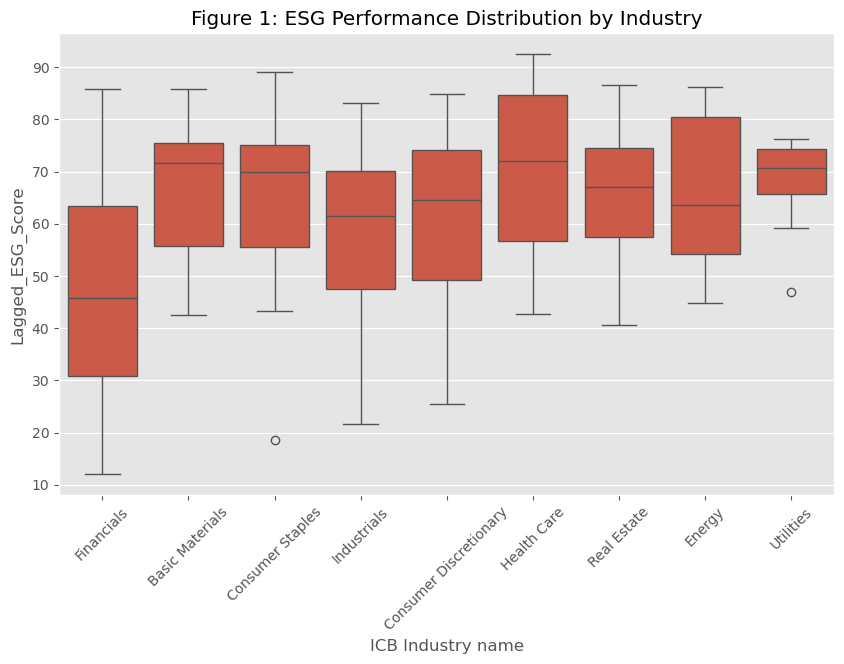

In [61]:
plt.figure(figsize=(10,6)) #Create a new figure with a specific width and height
sns.boxplot(x='ICB Industry name', y='Lagged_ESG_Score', data=data_merged) #Create a boxplot of ESG scores grouped by industry
plt.title("Figure 1: ESG Performance Distribution by Industry"); plt.xticks(rotation=45); plt.show() 
#Add title, rotate x-axis labels, and display the plot

##### The figure above indicates pronounced industry-level differences in ESG performance, with Health Care and Utilities consistently achieving higher median ESG scores, while Financials exhibit both lower central tendency and substantially greater dispersion, suggesting uneven ESG adoption and reporting practices within that sector.

#### Figure 2: Correlation Heatmap of Variables

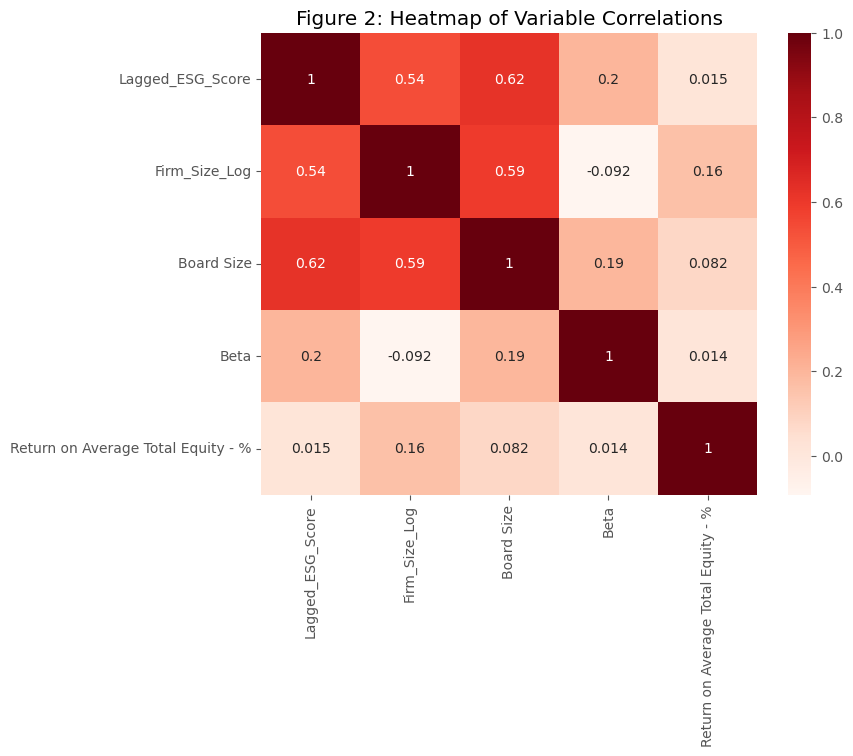

In [64]:
plt.figure(figsize=(8,6)) #Create a new figure with a specific width and height
sns.heatmap(data_merged[ml_features + [DV]].corr(), annot=True, cmap='Reds') #Generate a heatmap of correlations between selected features
plt.title("Figure 2: Heatmap of Variable Correlations"); plt.show() #Add a title and display the plot

#### Figure 3: Regression Fit of ESG VS Financial Performance

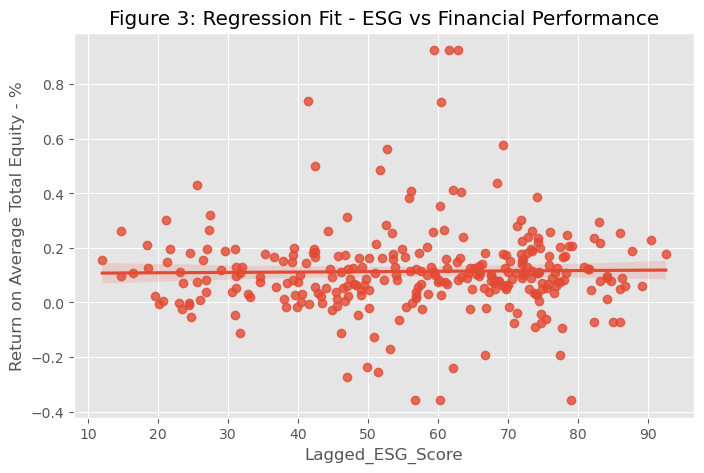

In [67]:
plt.figure(figsize=(8,5)) #Create a new figure with a specific width and height
sns.regplot(x='Lagged_ESG_Score', y=DV, data=data_merged) #Create a scatter plot with a linear regression line
plt.title("Figure 3: Regression Fit - ESG vs Financial Performance"); plt.show() #Add a title and display the plot

#### Figure 4: Moderation Interaction Plot

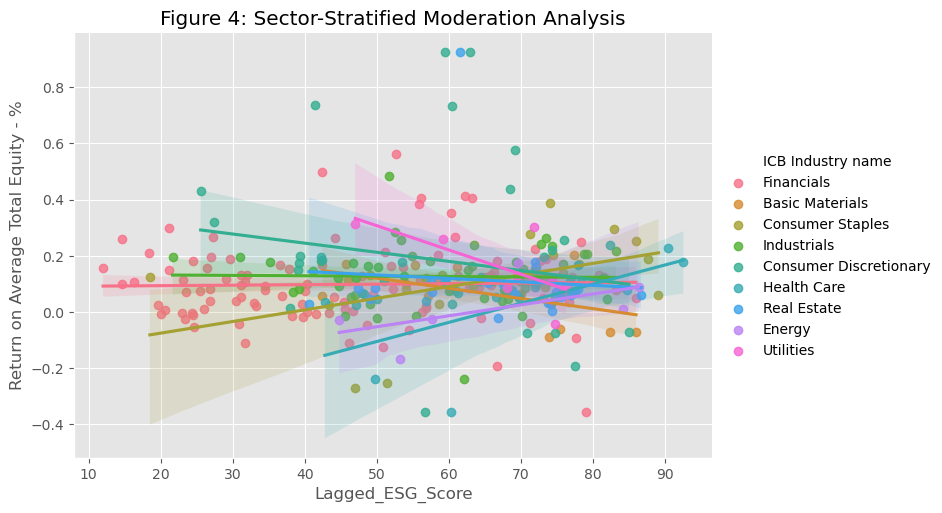

In [69]:
sns.lmplot(x='Lagged_ESG_Score', y=DV, hue='ICB Industry name', data=data_merged, height=5, aspect=1.5) #Create a faceted regression plot, coloured by sector
plt.title("Figure 4: Sector-Stratified Moderation Analysis"); plt.show() #Add a title and display the plot

#### Figure 5: Residual Plot

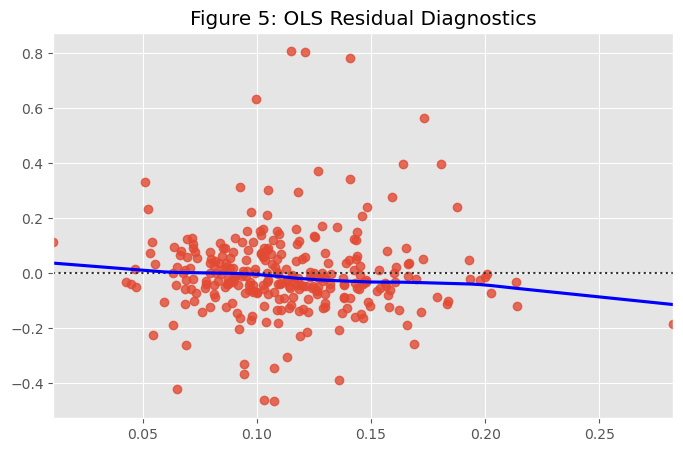

In [71]:
plt.figure(figsize=(8,5)) #Create a new figure with a specific width and height
sns.residplot(x=ols_results.fittedvalues, y=ols_results.resid, lowess=True, line_kws={'color': 'blue'}) #Plot residuals against fitted values with a LOESS smoother
plt.title("Figure 5: OLS Residual Diagnostics"); plt.show() #Add a title and display the plot

#### Figure 6: Feature Importance (Gradient Boosting)

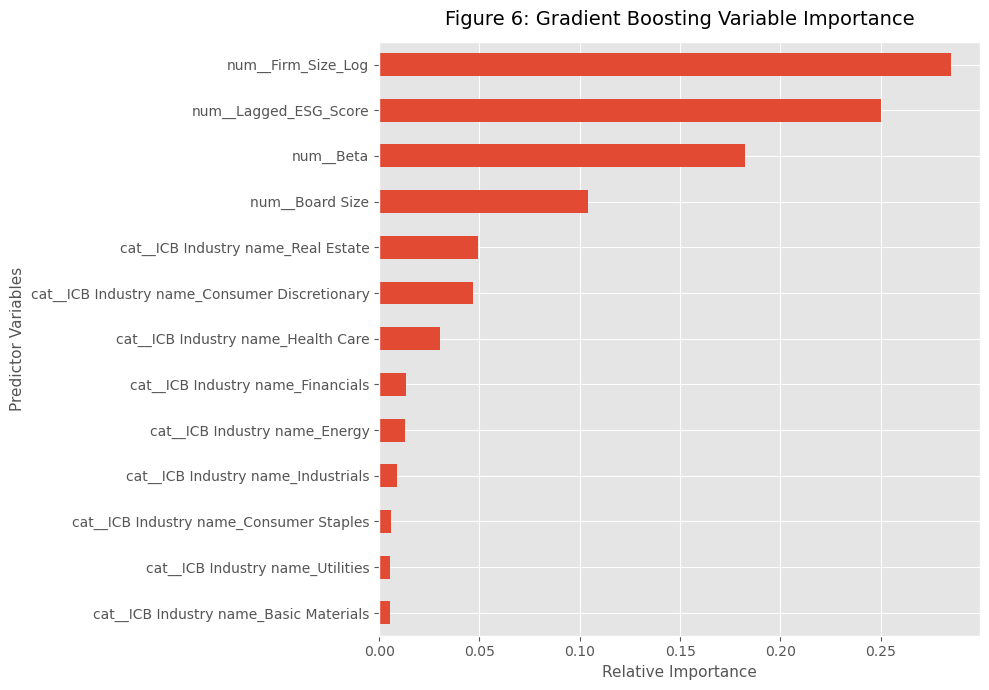

In [73]:
# Train Gradient Boosting model on preprocessed data
X_train_transformed = preprocessor.fit_transform(X_train)
best_gb = GradientBoostingRegressor(random_state=42).fit(
    X_train_transformed, y_train
)

# Retrieve feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Create feature importance Series
importance_df = (
    pd.Series(best_gb.feature_importances_, index=feature_names)
      .sort_values()
)
# Create figure and axis explicitly
fig, ax = plt.subplots(figsize=(10, 7))
# Horizontal bar plot
importance_df.plot(
    kind="barh",
    ax=ax
)
# Titles and labels
ax.set_title(
    "Figure 6: Gradient Boosting Variable Importance",
    fontsize=14,
    pad=12
)
ax.set_xlabel("Relative Importance", fontsize=11)
ax.set_ylabel("Predictor Variables", fontsize=11)
# Improve layout
fig.tight_layout()
# Save figure (downloadable)
output_path = "Figure_6_Gradient_Boosting_Variable_Importance.png"
fig.savefig(
    output_path,
    dpi=300,
    bbox_inches="tight"
)
# Display plot
plt.show()

#### Figure 7: Accuracy Benchmarking

/var/folders/db/51f_84g149q3w8sv_r0zs0480000gn/T/ipykernel_24801/3454798494.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='R2', data=res_df, palette='magma') #Create a bar plot comparing the R² scores of each model


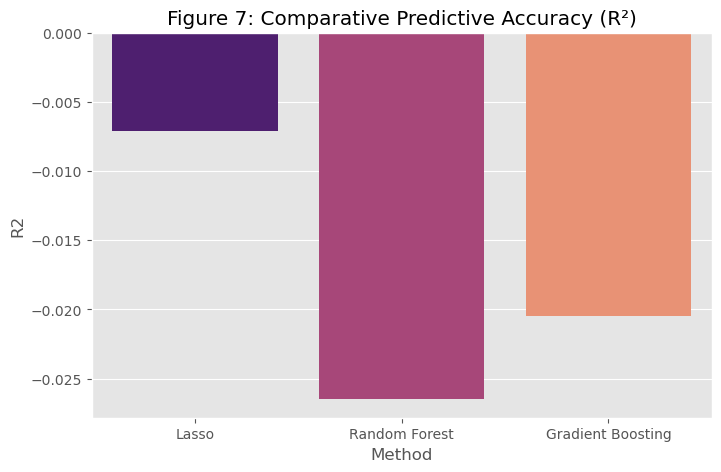

In [75]:
res_df = pd.DataFrame(summary_stats) #Convert the model results list into a DataFrame
plt.figure(figsize=(8,5)) #Create a new figure with a specific width and height
sns.barplot(x='Method', y='R2', data=res_df, palette='magma') #Create a bar plot comparing the R² scores of each model
plt.title("Figure 7: Comparative Predictive Accuracy (R²)"); plt.show() #Add a title and display the plot

#### Figure 8: Market Capitalisation Distribution by Sector (The Moderating Variable)

/var/folders/db/51f_84g149q3w8sv_r0zs0480000gn/T/ipykernel_24801/1325796043.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='ICB Industry name', y='Firm_Size_Log', data=data_merged, palette='muted')


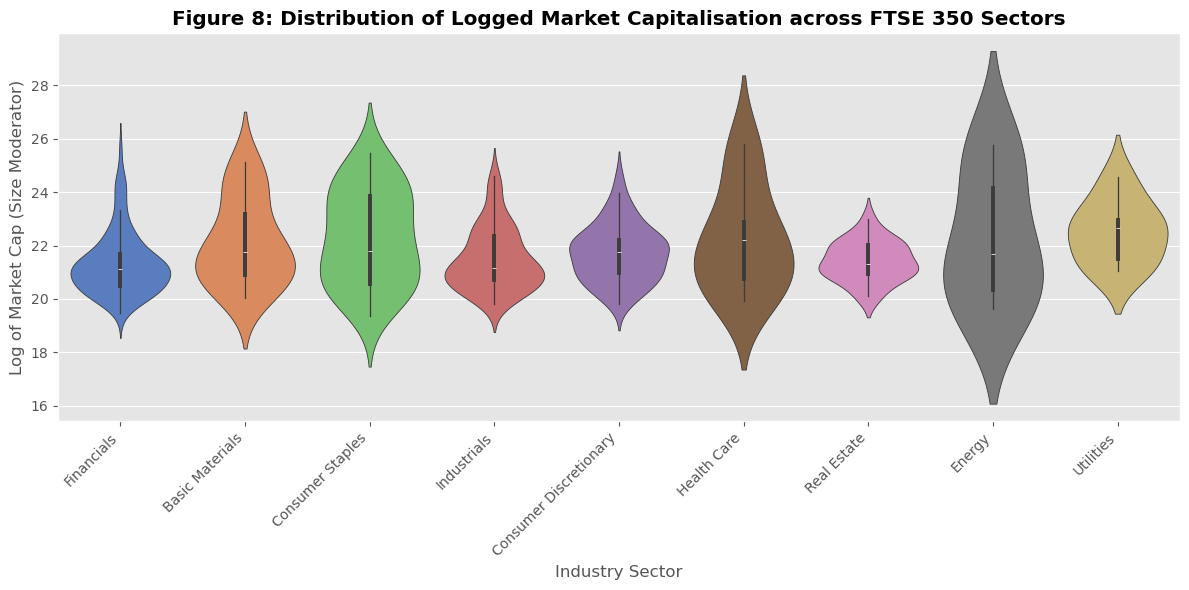

In [77]:
#Justification for using Log-Transformation in Section 3
plt.figure(figsize=(12, 6)) #Create a large figure for a detailed plot
#Create a violin plot showing distribution of logged market cap per sector
sns.violinplot(x='ICB Industry name', y='Firm_Size_Log', data=data_merged, palette='muted') 
plt.xticks(rotation=45, ha='right') #Rotate x-axis labels for readability
plt.title('Figure 8: Distribution of Logged Market Capitalisation across FTSE 350 Sectors', fontweight='bold') #Add a bold title
plt.ylabel('Log of Market Cap (Size Moderator)') #Label the y-axis
plt.xlabel('Industry Sector') #Label the x-axis
plt.tight_layout() #Adjust subplot parameters for a tidy layout
plt.show() #Display the plot

#### Figure 9: ESG Performance vs. Market Cap (Size Heterogeneity)

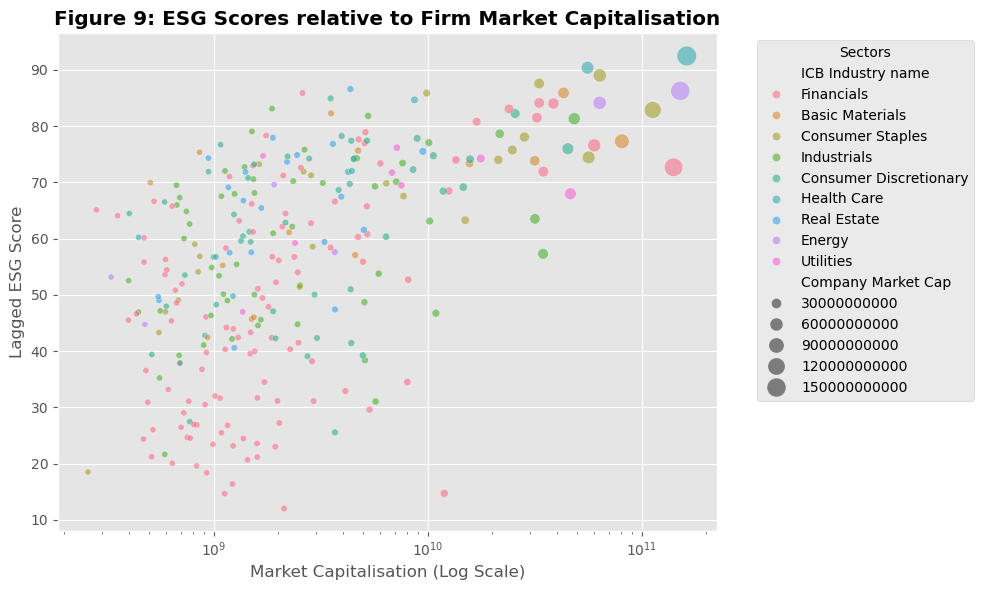

In [79]:
#Visualisation of why Firm Size acts as a moderator
plt.figure(figsize=(10, 6)) #Create a large figure for a detailed scatter plot
sns.scatterplot(data=data_merged, x='Company Market Cap', y='Lagged_ESG_Score', #Create a scatter plot with size and colour encoding
                hue='ICB Industry name', size='Company Market Cap', sizes=(20, 200), alpha=0.6)
plt.xscale('log') #Set the x-axis to a logarithmic scale to manage the wide spread of market cap values
plt.title('Figure 9: ESG Scores relative to Firm Market Capitalisation', fontweight='bold') #Add a bold title
plt.xlabel('Market Capitalisation (Log Scale)') #Label the x-axis
plt.ylabel('Lagged ESG Score') #Label the y-axis
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Sectors') #Place the legend outside the plot
plt.tight_layout() #Adjust subplot parameters for a tidy layout
plt.show() #Display the plot

#### Figure 10: Missing Data Heatmap (Pre-Imputation Audit)

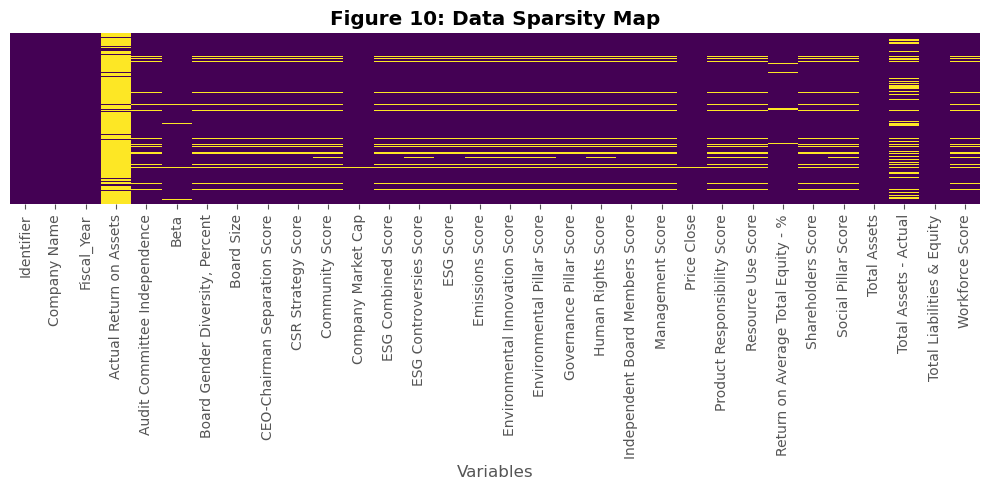

In [81]:
#Proof of data cleaning work from Section 2 (Industry Median Imputation)
plt.figure(figsize=(10, 5)) #Create a wide figure for the heatmap
#Create a heatmap showing missing values (yellow=missing)
sns.heatmap(df_reshaped.isnull(), yticklabels=False, cbar=False, cmap='viridis') 
plt.title('Figure 10: Data Sparsity Map', fontweight='bold') #Add a bold title
plt.xlabel('Variables') #Label the x-axis
plt.tight_layout() #Adjust subplot parameters for a tidy layout
plt.show() #Display the plot

#### Figure 11: ESG Trend Analysis

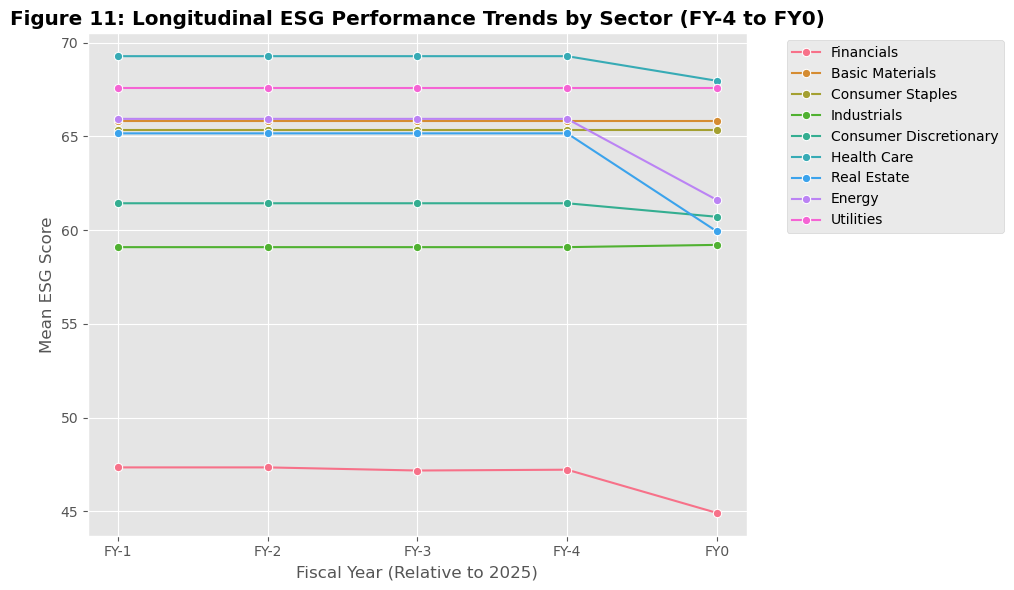

In [83]:
plt.figure(figsize=(10, 6)) #Create a large figure for a detailed line plot
sns.lineplot(data=df, x='Fiscal_Year', y='ESG Score', hue='ICB Industry name', marker='o', errorbar=None) #Plot ESG score over time, grouped by sector
plt.title('Figure 11: Longitudinal ESG Performance Trends by Sector (FY-4 to FY0)', fontweight='bold') #Add a bold title
plt.ylabel('Mean ESG Score') #Label the y-axis
plt.xlabel('Fiscal Year (Relative to 2025)') #Label the x-axis
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #Place the legend outside the plot
plt.tight_layout() #Adjust subplot parameters for a tidy layout
plt.show() #Display the plot

#### Figure 12: Sectoral ESG Leaders vs Laggards

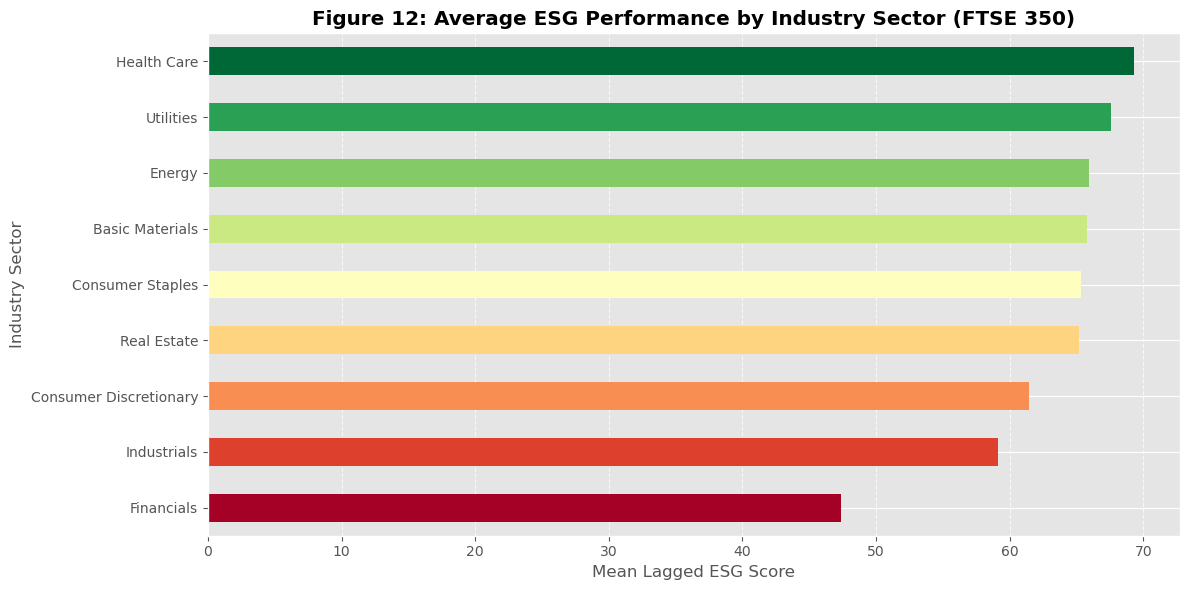

In [85]:
#Display mean ESG score per industry to highlight sector-level performance
plt.figure(figsize=(12, 6)) #Create a large figure for a horizontal bar plot
#Calculate and sort the mean ESG score per sector
sector_means = data_merged.groupby('ICB Industry name')['Lagged_ESG_Score'].mean().sort_values() 
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(sector_means))) #Create a colour gradient from red to green for the bars
sector_means.plot(kind='barh', color=colors) #Plot the sorted sector means as a horizontal bar chart
plt.title('Figure 12: Average ESG Performance by Industry Sector (FTSE 350)', fontweight='bold') #Add a bold title
plt.xlabel('Mean Lagged ESG Score') #Label the x-axis
plt.ylabel('Industry Sector') #Label the y-axis
plt.grid(axis='x', linestyle='--', alpha=0.7) #Add a dotted grid on the x-axis for readability
plt.tight_layout() #Adjust subplot parameters for a tidy layout
plt.show() #Display the plot

#### Figure 13: Interaction Heatmap (Market Cap vs ESG Score)

/var/folders/db/51f_84g149q3w8sv_r0zs0480000gn/T/ipykernel_24801/2287585949.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = data_merged.pivot_table(index='ESG_Bin', columns='Size_Bin', values=DV, aggfunc='mean')


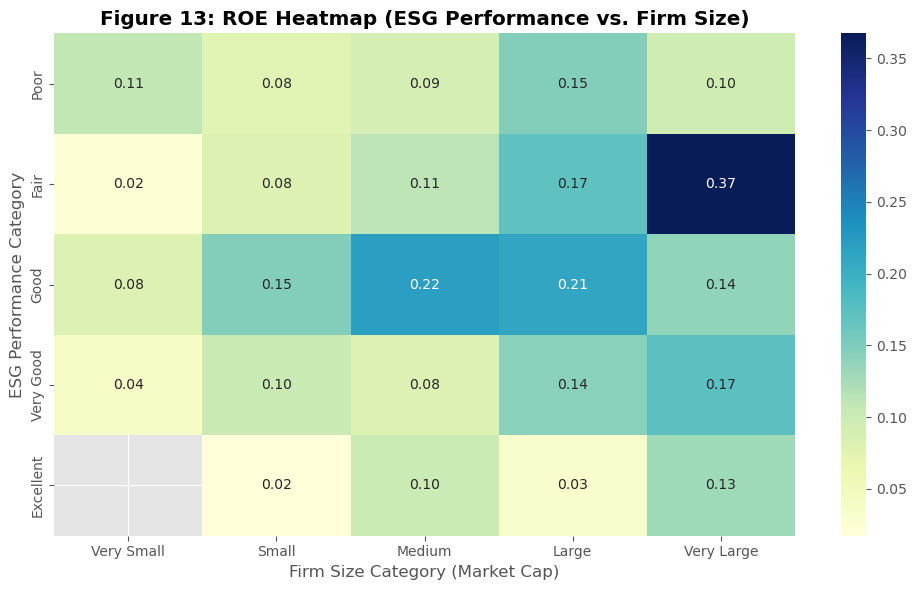

In [87]:
#Visualisation of the H2 Moderation Effect by clustering ROE values
plt.figure(figsize=(10, 6)) #Create a large figure for a heatmap
#Create bins for Size and ESG to make a heatmap
#Bin logged firm size into quintiles
data_merged['Size_Bin'] = pd.qcut(data_merged['Firm_Size_Log'], 5, labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large']) 
#Bin ESG scores into quintiles
data_merged['ESG_Bin'] = pd.qcut(data_merged['Lagged_ESG_Score'], 5, labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']) 
#Create a pivot table of mean ROE per ESG/Size bin
pivot_table = data_merged.pivot_table(index='ESG_Bin', columns='Size_Bin', values=DV, aggfunc='mean') 
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".2f") #Plot the heatmap with annotations
plt.title('Figure 13: ROE Heatmap (ESG Performance vs. Firm Size)', fontweight='bold') #Add a bold title
plt.xlabel('Firm Size Category (Market Cap)') #Label the x-axis
plt.ylabel('ESG Performance Category') #Label the y-axis
plt.tight_layout() #Adjust subplot parameters for a tidy layout
plt.show() #Display the plot

##### Additional Visualisations – Figure Notes for Visualisations Above
 This section provides brief descriptions of all visualisations generated during the analytical process. These figures support transparency, data understanding, and methodological justification. Core analytical figures are discussed in Chapter 5; the remaining figures are included here for completeness and technical documentation.

---

##### Figure 1: ESG Performance Distribution by Industry
This figure presents boxplots of lagged ESG scores across ICB industry classifications. It illustrates substantial cross-industry variation in ESG performance, with differing medians and dispersion levels, highlighting heterogeneity in baseline ESG engagement among FTSE 350 firms.

---

##### Figure 2: Heatmap of Variable Correlations
This figure displays pairwise correlations among key model variables, including ESG scores, financial performance metrics, firm size, and governance measures. The heatmap is used to assess linear associations and potential multicollinearity prior to regression modelling.

---

##### Figure 3: Regression Fit – ESG vs Financial Performance
 This figure plots lagged ESG scores against Return on Equity with a fitted linear regression line. The visualisation indicates a weak positive association between ESG performance and financial outcomes, accompanied by substantial dispersion, consistent with the low explanatory power observed in the regression results.

---

##### Figure 4: Sector-Stratified Moderation Analysis
This figure presents sector-stratified regression relationships between ESG performance and financial outcomes. Differences in slopes across sectors visually demonstrate heterogeneity in the ESG–financial performance relationship and support the presence of contextual variation across industries.

---

##### Figure 5: OLS Residual Diagnostics
This figure plots regression residuals against fitted values with a locally weighted smoothing line. It is used to assess model assumptions, including linearity and heteroscedasticity, and to evaluate whether residual patterns indicate systematic misspecification.

---

##### Figure 6: Gradient Boosting Variable Importance
This figure displays the relative importance of input variables within the Gradient Boosting model. The visualisation shows that traditional financial variables dominate predictive importance, while ESG-related variables contribute marginally, supporting conclusions regarding limited short-term predictive relevance.

---

##### Figure 7: Comparative Predictive Accuracy (R²)
This figure compares out-of-sample predictive accuracy (R²) across Lasso Regression, Random Forest, and Gradient Boosting models. The uniformly negative R² values indicate that ESG variables do not improve short-term prediction relative to a naïve benchmark.

---

##### Figure 8: Distribution of Logged Market Capitalisation
This figure presents the distribution of firm size measured as the logarithm of market capitalisation. The visualisation demonstrates reduced skewness following log transformation, justifying its use in regression modelling.

---

##### Figure 9: ESG Scores Relative to Firm Market Capitalisation
 This scatter plot displays ESG scores against firm market capitalisation on a logarithmic scale, with points coloured by industry sector. The figure illustrates the wide dispersion of ESG performance across firm sizes and sectors.

---

##### Figure 10: Data Sparsity Map
This figure presents a heatmap of missing values across variables prior to imputation. It provides visual evidence of data sparsity patterns and supports the use of industry-median imputation during data cleaning.

---

##### Figure 11: Longitudinal ESG Performance Trends by Sector
This figure shows mean ESG scores over time (FY-4 to FY0) across industry sectors. The visualisation highlights temporal stability and sectoral differences in ESG performance trajectories.

---

##### Figure 12: Average ESG Performance by Industry Sector (FTSE 350)
This figure presents average lagged ESG scores across industry sectors. It illustrates substantial baseline differences in ESG engagement and provides contextual background for interpreting sector-specific regression coefficients.

---

##### Figure 13: ROE Heatmap (ESG Performance vs Firm Size)
This figure displays mean Return on Equity across binned ESG performance and firm size categories. The heatmap illustrates non-linear patterns and interaction effects between ESG performance and organisational scale.